# Toy model: jueves

Vamos a entrenar un modelo de clasificación simple para ver en qué valores de accuracy nos movemos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/raw/covtype.csv")

En el paper indican que el dataset está ordenado, y que los primeros 11340 registros pertenecen al dataset utilizado para entrenar el modelo. Los siguientes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [4]:
train_size = 11340
validation_size = 3780

X = df.loc[:, :"Soil_Type40"]
y = df.iloc[:, -1]

del df

## Random Forest:

El modelo que vamos a utilizar en este primer intento de clasificar los tipos de espesura que cubren un terreno va a ser **Random Forest**. De todas formas, como este documento va a funcionar más como un banco de pruebas que como otra cosa, vamos a realizar algunos pasos innecesarios para comprobar cómo mejoran las métricas del modelo introduciendo distintas mejoras.

Modelos que vamos a entrenar:
- Con solo 10 variables numéricas continuas:
    1. RandomForest, 100 árboles de decisión, variables sin escalar.
- Con todas las variables, incluidas las categóricas:
    1. RandomForest 100, variables sin escalar
    2. RandomForest 100, variables escaladas
- Grid Search CV, parámetros que vamos a estudiar:
    1. n_estimators
    2. max_depth
    3. Más adelante: max_leafs? max_features? Mirar significado exacto de cada parámetro.

In [6]:
X.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [7]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
minmax.fit(X) # Watch out! Data scaling must be made with the whole dataset, not just with the training data

MinMaxScaler()

Separar el X_train, X_validation y X_test:

In [9]:
X_train = X.iloc[:train_size, :]
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size+validation_size:, :]
y_test = y.iloc[train_size+validation_size:]

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11340, 54) (11340,)
(565891, 54) (565891,)


### Solo 10 variables numéricas continuas:

A modo de prueba, vamos a ignorar la variable `Wilderness Area` repartida en 4 columnas y las 40 columnas correspondientes al tipo de terreno. Entrenaremos un modelo y veremos su accuracy.

In [13]:
X_train_short = X_train.loc[:, :"Horizontal_Distance_To_Fire_Points"]
X_test_short = X_test.loc[:, :"Horizontal_Distance_To_Fire_Points"]

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

rf_1 = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 5,
    min_samples_leaf = 50,
    random_state = 42,
)

rf_1.fit(X_train_short, y_train)
y_predict = rf_1.predict(X_test_short)
print("n_estimators = 100, Random Forest, Features = 10, Accuracy:\t", accuracy_score(y_test, y_predict))

NameError: name 'X_test_short' is not defined

In [20]:
del X_train_short, X_test_short # Borramos para liberar memoria

### Todas las columnas:

Esta vez, vamos a usar todas las columnas del dataset. Vamos a comparar la influencia que tiene la normalización (MinMaxScaler, la usada en el artículo).

#### Variables sin escalar:

In [23]:
rf_2 = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 5,
    min_samples_leaf = 50,
    random_state = 42,
)

rf_2.fit(X_train, y_train)
y_predict = rf_2.predict(X_test)
print("n_estimators = 100, Random Forest, Features = 40, Accuracy:\t", accuracy_score(y_test, y_predict))

n_estimators = 100, Random Forest, Features = 40, Accuracy:	 0.49417820746398156


#### Variables escaladas:

In [24]:
X_train_scaled = minmax.transform(X_train)
X_test_scaled = minmax.transform(X_test)

rf_3 = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 5,
    min_samples_leaf = 50,
    random_state = 42,
)

rf_3.fit(X_train_scaled, y_train)
y_predict = rf_3.predict(X_test_scaled)
print("n_estimators = 100, Random Forest, Features = 40, Scaled, Accuracy:\t", accuracy_score(y_test, y_predict))

n_estimators = 100, Random Forest, Features = 40, Scaled, Accuracy:	 0.4941852759630388


### Preliminary Results:

- Model 1: 10 features, not scaled, n_estimators = 100, max_depth = 5.
    - Accuracy: 0.47
- Model 2: 40 features, not scaled, n_estimators = 100, max_depth = 5.
    - Accuracy: 0.49417820746398156
- Model 3: 40 features, scaled, SAME:
    - Accuracy: 0.4941852759630388

Conclusiones:
1. Incluir todas las features mejora el accuracy en un 2%.
2. Escalar las variables mejora el accuracy en un 0.001%. Esto tiene sentido, ya que el DecisionTreeClassifier (base del RandomForest) puede funcionar bien sin necesidad de escalar las variables predictoras.

### Grid Search:

Nuestro accuracy sigue estando bastante por debajo del modelo Linear Discriminant Analysis del paper (58%). Vamos a realizar un Grid Search para ver si podemos al menos acercarnos a dicho valor.

In [27]:
from sklearn.model_selection import GridSearchCV

estimator = RandomForestClassifier(
    random_state = 42,
)

parametros = {
    "n_estimators": [50, 75, 100, 150, 200, 250],
    "max_depth": [5, 10, 12, 15, 17, 20],
}

gs = GridSearchCV(
    estimator = estimator,
    param_grid = parametros,
    scoring = "accuracy",
    cv = 5,
    verbose = 3,
)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.425 total time=   0.4s
[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.634 total time=   0.2s
[CV 3/5] END ......max_depth=5, n_estimators=50;, score=0.591 total time=   0.2s
[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.591 total time=   0.2s
[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.618 total time=   0.2s
[CV 1/5] END ......max_depth=5, n_estimators=75;, score=0.417 total time=   0.4s
[CV 2/5] END ......max_depth=5, n_estimators=75;, score=0.642 total time=   0.4s
[CV 3/5] END ......max_depth=5, n_estimators=75;, score=0.585 total time=   0.4s
[CV 4/5] END ......max_depth=5, n_estimators=75;, score=0.603 total time=   0.4s
[CV 5/5] END ......max_depth=5, n_estimators=75;, score=0.634 total time=   0.5s
[CV 1/5] END .....max_depth=5, n_estimators=100;, score=0.427 total time=   0.6s
[CV 2/5] END .....max_depth=5, n_estimators=100

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 12, 15, 17, 20],
                         'n_estimators': [50, 75, 100, 150, 200, 250]},
             scoring='accuracy', verbose=3)

In [38]:
best_rf = gs.best_params_
best_rf

{'max_depth': 12, 'n_estimators': 250}

In [29]:
gs.best_score_

np.float64(0.613668430335097)

In [30]:
y_predict = gs.predict(X_test_scaled)

In [33]:
print(f"Accuracy: {accuracy_score(y_test, y_predict):5.3f}")

Accuracy: 0.670


In [39]:
print(f"Train Accuracy: {accuracy_score(y_train, gs.predict(X_train_scaled))}")

Train Accuracy: 0.9167548500881835


<Axes: >

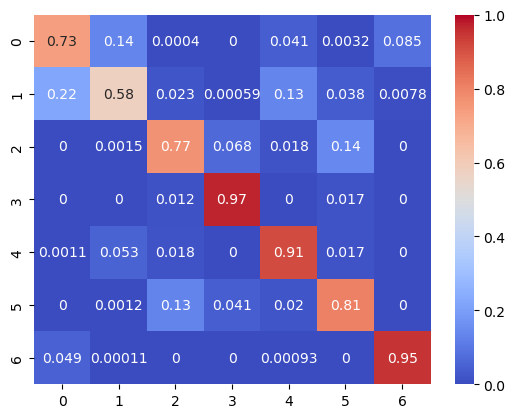

In [37]:
sns.heatmap(confusion_matrix(y_test, y_predict, normalize = "true"), cmap = "coolwarm", vmin = 0, vmax = 1, annot = True)

**OJO:**

Hemos llegado al 67% de precisión. Estamos a un 3% de alcanzar la Red Neuronal del artículo.

### Save the best model to a Pickle file:

In [40]:
import pickle

In [41]:
with open("./models/rf_grid_search.pkl", "wb") as file:
    pickle.dump(gs, file)

## Ensemble models: boosting

Vamos a intentar lo mismo. Haremos dos GridSearchCV para estudiar si estos mejoran los resultados de los modelos de Bagging como el Random Forest.

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(
    estimator = DecisionTreeClassifier(),
    random_state = 42,
)

params_ada = {
    "n_estimators": [50, 100, 150, 175, 200, 250],
    "learning_rate": [0.1, 0.25, 0.5, 0.75],
    "estimator__max_depth": [10, 12, 15],
}

gs_ada = GridSearchCV(
    estimator = ada,
    param_grid = params_ada,
    scoring = "accuracy",
    cv = 5,
    verbose = 3,
)

In [45]:
gs_ada.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END estimator__max_depth=10, learning_rate=0.1, n_estimators=50;, score=0.503 total time=   5.3s
[CV 2/5] END estimator__max_depth=10, learning_rate=0.1, n_estimators=50;, score=0.628 total time=   4.9s
[CV 3/5] END estimator__max_depth=10, learning_rate=0.1, n_estimators=50;, score=0.581 total time=   4.9s
[CV 4/5] END estimator__max_depth=10, learning_rate=0.1, n_estimators=50;, score=0.609 total time=   5.3s
[CV 5/5] END estimator__max_depth=10, learning_rate=0.1, n_estimators=50;, score=0.569 total time=   4.9s
[CV 1/5] END estimator__max_depth=10, learning_rate=0.1, n_estimators=100;, score=0.523 total time=  10.1s
[CV 2/5] END estimator__max_depth=10, learning_rate=0.1, n_estimators=100;, score=0.638 total time=  10.6s
[CV 3/5] END estimator__max_depth=10, learning_rate=0.1, n_estimators=100;, score=0.582 total time=  10.2s
[CV 4/5] END estimator__max_depth=10, learning_rate=0.1, n_estimators=100;, score=0.609

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=42),
             param_grid={'estimator__max_depth': [10, 12, 15],
                         'learning_rate': [0.1, 0.25, 0.5, 0.75],
                         'n_estimators': [50, 100, 150, 175, 200, 250]},
             scoring='accuracy', verbose=3)

In [46]:
with open("./models/ada_boost_grid_search.pkl", "wb") as file:
    pickle.dump(gs_ada, file)

In [47]:
print(f"Ada Boost accuracy: {accuracy_score(y_test, gs_ada.predict(X_test_scaled))}")

Ada Boost accuracy: 0.7436502789406441
